# Nowcasting

## Packages and Setting

In [1]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from functools import reduce
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from ExtendedDynamicFactor import ExtendedDynamicFactor, OptimizeExtendedDynamicFactor

%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

## Loading Dataset

In [2]:
def load_gdp(growth=True, quarterly=True, **kwargs):
    gdp = pd.read_csv('data/GDP_2014USD.csv')[['date', 'PH']].rename(columns={'PH': 'GDP'}).dropna()
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp = gdp.set_index('date')
    if quarterly:
        gdp = gdp.resample('Q').sum()
        gdp = 100 * (gdp / gdp.shift(4) - 1) if growth else gdp
    else:
        gdp = gdp.resample('Y').sum()
        gdp = 100 * (gdp / gdp.shift(1) - 1) if growth else gdp

    return gdp.dropna()

In [3]:
def load_tweets(keywords=['PE'], metrics=['TBweight_cl2rt', 'VADERweight_cl2rt'], **kwargs):
    tweets = pd.read_csv('data/PH_Tweets.csv')
    tweets['date'] = pd.to_datetime(tweets['date'])
    tweets = tweets.set_index('date')
    keywords = keywords if len(keywords) > 0 else list(tweets['keyword'].unique())
    metrics = metrics if len(metrics) > 0 else list(tweets.columns.drop(['keyword']))
    tweets = tweets[metrics + ['keyword']]
    tweets_keyword = [tweets[tweets['keyword'] == keyword].drop(columns=['keyword']).add_suffix(f'_{keyword}') for keyword in keywords]
    tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), tweets_keyword)

    return tweets

In [4]:
def load_data(vintage, window=0, scaled=True, **kwargs):
    # READ GDP DATA
    lag = 41
    gdp = load_gdp(**kwargs)
    gdp = gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    gdp_scaler = StandardScaler(with_mean=scaled, with_std=scaled).fit(gdp[['GDP']])
    gdp['GDP'] = gdp_scaler.transform(gdp[['GDP']])
    gdp.index = pd.PeriodIndex(gdp.index, freq='M')

    # READ TWEET DATA
    tweets = load_tweets(**kwargs)
    tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
    tweets.index = pd.PeriodIndex(tweets.index, freq='M')
    
    # MERGE DATA
    while tweets.index[-1].month % 3 != 0:
        tweets.loc[tweets.index[-1] + pd.offsets.MonthEnd(1), :] = np.nan
    tweets = pd.concat([tweets.shift(l).add_suffix(f'.L{l}') for l in range(3)], axis=1)
    tweets = tweets.loc[tweets.index.month % 3 == 0, :]
    df = pd.merge(tweets, gdp, how='outer', on='date', sort=True)
    df.index = pd.PeriodIndex(df.index, freq='Q')
    df = df.tail(math.ceil(window / 3)) if window > 0 else df

    return df, gdp_scaler

## Quarter to Annual GDP Growth Conversion

In [5]:
def quarter_to_annual(vintage, nowcasts):
    # LOAD GDP DATA
    lag = 41
    quarter_gdp = load_gdp(False, True)
    quarter_gdp = quarter_gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    quarter_gdp.index = pd.PeriodIndex(quarter_gdp.index, 'Q')
    annual_gdp = load_gdp(False, False)
    annual_gdp = annual_gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    annual_gdp.index = pd.PeriodIndex(annual_gdp.index, 'Y')

    # GET QUARTERLY GDP
    for m in range(4):
        quarter = 3 * (m + 1)
        prev_quarter = vintage - relativedelta(years=1) + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[prev_quarter, 'GDP'] * (1 + nowcasts[m] / 100)
        # PAD OBSERVED
        curr_quarter = vintage + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[curr_quarter, 'GDP'] if curr_quarter in quarter_gdp.index else nowcasts[m]
    
    # GET ANNUAL GDP GROWTH
    prev_year = vintage - relativedelta(years=1)
    return 100 * (np.sum(nowcasts) / annual_gdp.loc[prev_year, 'GDP'] - 1)

## Dynamic Factor Model

In [6]:
def load_DFMmodel(vintage_now, factor_order, error_order, k_factors, factor_lag, window, optimize_order, **kwargs):
    # LOAD DATA
    df, gdp_scaler = load_data(vintage_now, window, **kwargs)
    
    # FIT MODEL
    if optimize_order:
        model = OptimizeExtendedDynamicFactor(
            endog=df, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
            error_order=error_order, **kwargs
        ).optimize(**kwargs)
    else:
        model = ExtendedDynamicFactor(
            endog=df, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
            error_order=error_order, **kwargs
        )
    results = model.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
    
    return results, (model.factor_order, model.error_order, model.k_factors, model.factor_lag), gdp_scaler

In [7]:
def runDFM(factor_order, error_order, k_factors, factor_lag, window=0, optimize_order=False, **kwargs):
    # PRINT SPECIFICATIONS
    print(f'DFM Order: ({factor_order}, {error_order}, {k_factors}, {factor_lag})')
    if optimize_order:
        print('[WARNING] Input orders are used as upper limits with optimize_order')
    print(f'Window: {window}')

    # LOAD ACTUAL GDP
    actual_gdp = load_gdp(True, False)
    actual_gdp.index = pd.PeriodIndex(actual_gdp.index, 'Y')

    # SAVED RESULTS
    results = []
    if not os.path.exists(f'Results'):
        os.makedirs(f'Results')

    # FORECAST DATES   
    vintage_now = dt.datetime(2017, 1, 1)
    vintage_end = dt.datetime(2022, 12, 1)
    delta = relativedelta(months=1)

    while vintage_now <= vintage_end:
        # GET ACTUAL GDP
        actual = actual_gdp.loc[vintage_now, 'GDP']
        
        try:
            # FIT MODEL
            model, (factor_order, error_order, k_factors, factor_lag), gdp_scaler = load_DFMmodel(vintage_now, factor_order, error_order, k_factors, factor_lag, window, optimize_order, **kwargs)
            
            # CURRENT VINTAGE
            print(f'Vintage: {vintage_now.date()} \t {(factor_order, error_order, k_factors, factor_lag)}')
                
            # GET FORECASTS
            nowcasts = model.predict(start=f'{vintage_now.year}Q1', end=f'{vintage_now.year}Q4')[['GDP']]
            nowcasts = list(gdp_scaler.inverse_transform(nowcasts[['GDP']]).squeeze())
            nowcast = quarter_to_annual(vintage_now, nowcasts)
            
            # APPEND RESULTS
            results.append([vintage_now, vintage_now.year, (factor_order, error_order, k_factors, factor_lag), nowcast, actual])
        
        except Exception as ex:
            with open(f'Results/DFM_{str(vintage_now.date())}_W{window}_error.txt', 'w') as f:
                f.write(str(ex))
            
            results.append([vintage_now, vintage_now.year, (factor_order, error_order, k_factors, factor_lag), np.nan, actual])

        vintage_now += delta

    # SUMMARIZE RESULTS
    results = pd.DataFrame(results, columns=['date', 'Target', 'Order', 'Nowcast', 'Actual'])
    results['date'] = pd.to_datetime(results['date'])
    results['Period'] = np.where(results['Target'] < 2020, 1, 0)
    results['Year'] = results['Target']
    results['Month'] = results['date'].dt.month % 12

    # RMSE CALCULATIONS
    results['Difference'] = results['Nowcast'] - results['Actual']
    results['Overall RMSE'] = np.sqrt(np.power(results['Difference'].dropna(), 2).mean())
    for period in ['Month', 'Year', 'Period']:
        results = results.set_index(period)
        results[f'{period} RMSE'] = results.groupby(period).apply(lambda dff: np.sqrt(np.power(dff['Difference'].dropna(), 2).mean()))
        results = results.reset_index()
    results = results.drop(columns=['Period', 'Year', 'Month'])

    # SAVE AGGREGATED RESULTS
    if kwargs.get('save_aggregate', True):
        header = 'DFM_OPT' if optimize_order else f'DFM({factor_order},{error_order},{k_factors},{factor_lag})'
        results.to_csv(f'Results/{header}_W{window}_summary.csv', index=False)
    
    return results

DFM Order: (1, 1, 1, 0)
Window: 0
Vintage: 2017-01-01 	 (1, 1, 1, 0)
Vintage: 2017-02-01 	 (1, 1, 1, 0)
Vintage: 2017-03-01 	 (1, 1, 1, 0)
Vintage: 2017-04-01 	 (1, 1, 1, 0)
Vintage: 2017-05-01 	 (1, 1, 1, 0)
Vintage: 2017-06-01 	 (1, 1, 1, 0)
Vintage: 2017-07-01 	 (1, 1, 1, 0)
Vintage: 2017-08-01 	 (1, 1, 1, 0)
Vintage: 2017-09-01 	 (1, 1, 1, 0)
Vintage: 2017-10-01 	 (1, 1, 1, 0)
Vintage: 2017-11-01 	 (1, 1, 1, 0)
Vintage: 2017-12-01 	 (1, 1, 1, 0)
Vintage: 2018-01-01 	 (1, 1, 1, 0)
Vintage: 2018-02-01 	 (1, 1, 1, 0)
Vintage: 2018-03-01 	 (1, 1, 1, 0)
Vintage: 2018-04-01 	 (1, 1, 1, 0)
Vintage: 2018-05-01 	 (1, 1, 1, 0)
Vintage: 2018-06-01 	 (1, 1, 1, 0)
Vintage: 2018-07-01 	 (1, 1, 1, 0)
Vintage: 2018-08-01 	 (1, 1, 1, 0)
Vintage: 2018-09-01 	 (1, 1, 1, 0)
Vintage: 2018-10-01 	 (1, 1, 1, 0)
Vintage: 2018-11-01 	 (1, 1, 1, 0)
Vintage: 2018-12-01 	 (1, 1, 1, 0)
Vintage: 2019-01-01 	 (1, 1, 1, 0)
Vintage: 2019-02-01 	 (1, 1, 1, 0)
Vintage: 2019-03-01 	 (1, 1, 1, 0)
Vintage: 2019-04-01 	

,date,Target,Order,Nowcast,Actual,Difference,Overall RMSE,Month RMSE,Year RMSE,Period RMSE
0,2017-01-01,2017,"(1, 1, 1, 0)",NaN,6.930988,NaN,5.283497,NaN,0.277701,0.253630
1,2017-02-01,2017,"(1, 1, 1, 0)",NaN,6.930988,NaN,5.283497,NaN,0.277701,0.253630
2,2017-03-01,2017,"(1, 1, 1, 0)",6.770068,6.930988,-0.160921,5.283497,7.582713,0.277701,0.253630
3,2017-04-01,2017,"(1, 1, 1, 0)",6.770168,6.930988,-0.160821,5.283497,7.480777,0.277701,0.253630
4,2017-05-01,2017,"(1, 1, 1, 0)",6.812196,6.930988,-0.118793,5.283497,7.534073,0.277701,0.253630
...,...,...,...,...,...,...,...,...,...,...
67,2022-08-01,2022,"(1, 1, 1, 0)",7.786207,7.599235,0.186971,5.283497,5.602982,0.881130,7.467688
68,2022-09-01,2022,"(1, 1, 1, 0)",7.731489,7.599235,0.132253,5.283497,0.581392,0.881130,7.467688
69,2022-10-01,2022,"(1, 1, 1, 0)",7.602292,7.599235,0.003057,5.283497,1.147096,0.881130,7.467688
70,2022-11-01,2022,"(1, 1, 1, 0)",7.090382,7.599235,-0.508853,5.283497,1.183129,0.881130,7.467688


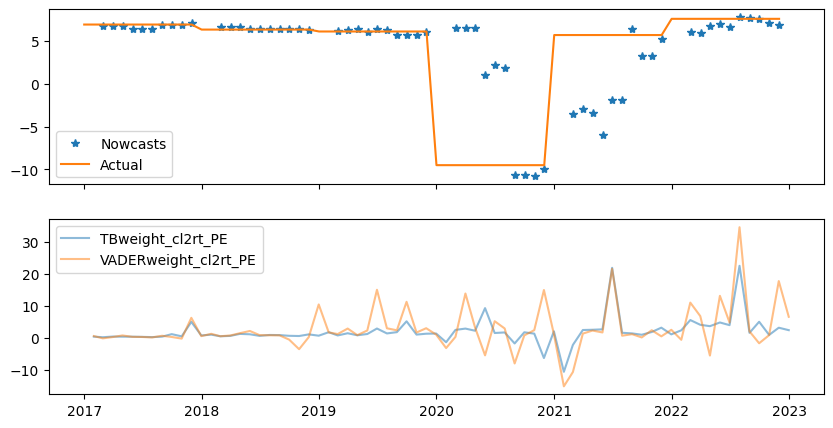

In [8]:
results = runDFM(factor_order=1, error_order=1, k_factors=1, factor_lag=0, window=0, optimize_order=False)
# results = pd.read_csv('Results/(1,1,1,0)_W0_summary.csv', parse_dates=['date'])
tweets = load_tweets().loc[dt.datetime(2017,1,1):,:]
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(results['date'], results['Nowcast'], linewidth=0, marker='*', label='Nowcasts')
axs[0].plot(results['date'], results['Actual'], label='Actual')
for metric in tweets.columns:
    axs[1].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[0].legend()
axs[1].legend()
fig.show()
results

## Machine Learning

In [9]:
def runML(window=0, gdp_lag=1, with_text=True, **kwargs):
    # PRINT SPECIFICATIONS
    print(f'Window: {window}')

    # LOAD ACTUAL GDP
    actual_gdp = load_gdp(True, False)
    actual_gdp.index = pd.PeriodIndex(actual_gdp.index, 'Y')

    # SAVED RESULTS
    results = []
    if not os.path.exists(f'Results'):
        os.makedirs(f'Results')

    # FORECAST DATES   
    vintage_now = dt.datetime(2017, 12, 31)
    vintage_end = dt.datetime(2022, 12, 31)
    delta = relativedelta(years=1)

    while vintage_now <= vintage_end:
        # GET ACTUAL GDP
        actual = actual_gdp.loc[vintage_now, 'GDP']
        
        try:
            # FIT MODEL
            df, gdp_scaler = load_data(vintage_now, window, False, **kwargs)
            df = df if with_text else df[['GDP']]
            df = pd.concat([df] + [df[['GDP']].shift(l).add_suffix(f'.L{l}') for l in range(1, gdp_lag + 1)], axis=1)
            df = df.iloc[gdp_lag:,:]
            X_test = df.loc[vintage_now+relativedelta(month=3):, df.columns.drop('GDP')]
            X_train = df.loc[:vintage_now-relativedelta(months=3), df.columns.drop('GDP')]
            y_train = df.loc[:vintage_now-relativedelta(months=3), 'GDP']
            model = ElasticNet()
            model.fit(X_train, y_train)

            # CURRENT VINTAGE
            print(f'Vintage: {vintage_now.date()}')
                
            # GET FORECASTS
            nowcasts = model.predict(X_test)
            nowcasts = list(gdp_scaler.inverse_transform(nowcasts.reshape(-1,1)).squeeze())
            nowcast = quarter_to_annual(vintage_now, nowcasts)
            
            # APPEND RESULTS
            results.append([vintage_now, vintage_now.year, model.score(X_train, y_train), nowcast, actual])
        
        except Exception as ex:
            with open(f'Results/ML_{str(vintage_now.date())}_W{window}_error.txt', 'w') as f:
                f.write(str(ex))
            
            results.append([vintage_now, vintage_now.year, np.nan, np.nan, actual])

        vintage_now += delta

    # SUMMARIZE RESULTS
    results = pd.DataFrame(results, columns=['date', 'Target', 'R2', 'Nowcast', 'Actual'])
    results['date'] = pd.to_datetime(results['date'])
    results['Period'] = np.where(results['Target'] < 2020, 1, 0)
    results['Year'] = results['Target']
    results['Month'] = results['date'].dt.month % 12

    # RMSE CALCULATIONS
    results['Difference'] = results['Nowcast'] - results['Actual']
    results['Overall RMSE'] = np.sqrt(np.power(results['Difference'].dropna(), 2).mean())
    for period in ['Month', 'Year', 'Period']:
        results = results.set_index(period)
        results[f'{period} RMSE'] = results.groupby(period).apply(lambda dff: np.sqrt(np.power(dff['Difference'].dropna(), 2).mean()))
        results = results.reset_index()
    results = results.drop(columns=['Period', 'Year', 'Month'])

    # SAVE AGGREGATED RESULTS
    if kwargs.get('save_aggregate', True):
        results.to_csv(f'Results/ML_W{window}_summary.csv', index=False)
    
    return results

Window: 0
Vintage: 2017-12-31
Vintage: 2018-12-31
Vintage: 2019-12-31
Vintage: 2020-12-31
Vintage: 2021-12-31
Vintage: 2022-12-31


,date,Target,R2,Nowcast,Actual,Difference,Overall RMSE,Month RMSE,Year RMSE,Period RMSE
0,2017-12-31,2017,0.369630,6.956904,6.930988,0.025916,2.281243,2.281243,0.025916,0.046439
1,2018-12-31,2018,0.331733,6.321949,6.341486,-0.019537,2.281243,2.281243,0.019537,0.046439
2,2019-12-31,2019,0.295557,6.044930,6.118526,-0.073596,2.281243,2.281243,0.073596,0.046439
3,2020-12-31,2020,0.924982,-4.008899,-9.518295,5.509396,2.281243,2.281243,5.509396,3.225831
4,2021-12-31,2021,0.830500,4.786422,5.703156,-0.916734,2.281243,2.281243,0.916734,3.225831
5,2022-12-31,2022,0.809043,7.443962,7.599235,-0.155273,2.281243,2.281243,0.155273,3.225831


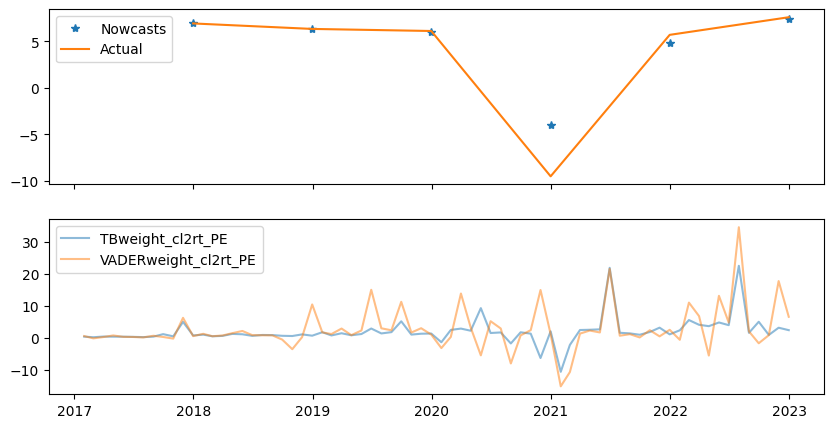

In [10]:
results = runML(window=0, gdp_lag=1)
# results = pd.read_csv('Results/ML_W0_summary.csv', parse_dates=['date'])
tweets = load_tweets().loc[dt.datetime(2017,1,1):,:]
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(results['date'], results['Nowcast'], linewidth=0, marker='*', label='Nowcasts')
axs[0].plot(results['date'], results['Actual'], label='Actual')
for metric in tweets.columns:
    axs[1].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[0].legend()
axs[1].legend()
fig.show()
results

## Autoregression

In [11]:
def runAR(lag, window=0, **kwargs):
    # PRINT SPECIFICATIONS
    print(f'AR Order: {lag}')
    print(f'Window: {window}')

    # LOAD ACTUAL GDP
    actual_gdp = load_gdp(True, False)
    actual_gdp.index = pd.PeriodIndex(actual_gdp.index, 'Y')

    # SAVED RESULTS
    results = []
    if not os.path.exists(f'Results'):
        os.makedirs(f'Results')

    # FORECAST DATES   
    vintage_now = dt.datetime(2017, 1, 1)
    vintage_end = dt.datetime(2022, 12, 1)
    delta = relativedelta(months=1)

    while vintage_now <= vintage_end:
        # GET ACTUAL GDP
        actual = actual_gdp.loc[vintage_now, 'GDP']
        
        try:
            # FIT MODEL
            df, gdp_scaler = load_data(vintage_now, window, **kwargs)
            model = AutoReg(df['GDP'].dropna(), lags=lag).fit() 

            # CURRENT VINTAGE
            print(f'Vintage: {vintage_now.date()}')
                
            # GET FORECASTS
            nowcasts = model.predict(start=f'{vintage_now.year}Q1', end=f'{vintage_now.year}Q4')
            nowcasts = list(gdp_scaler.inverse_transform(nowcasts.to_numpy().reshape(-1,1)).squeeze())
            nowcast = quarter_to_annual(vintage_now, nowcasts)
            
            # APPEND RESULTS
            results.append([vintage_now, vintage_now.year, lag, nowcast, actual])
        
        except Exception as ex:
            with open(f'Results/AR_{str(vintage_now.date())}_W{window}_error.txt', 'w') as f:
                f.write(str(ex))
            
            results.append([vintage_now, vintage_now.year, lag, np.nan, actual])

        vintage_now += delta

    # SUMMARIZE RESULTS
    results = pd.DataFrame(results, columns=['date', 'Target', 'Order', 'Nowcast', 'Actual'])
    results['date'] = pd.to_datetime(results['date'])
    results['Period'] = np.where(results['Target'] < 2020, 1, 0)
    results['Year'] = results['Target']
    results['Month'] = results['date'].dt.month % 12

    # RMSE CALCULATIONS
    results['Difference'] = results['Nowcast'] - results['Actual']
    results['Overall RMSE'] = np.sqrt(np.power(results['Difference'].dropna(), 2).mean())
    for period in ['Month', 'Year', 'Period']:
        results = results.set_index(period)
        results[f'{period} RMSE'] = results.groupby(period).apply(lambda dff: np.sqrt(np.power(dff['Difference'].dropna(), 2).mean()))
        results = results.reset_index()
    results = results.drop(columns=['Period', 'Year', 'Month'])

    # SAVE AGGREGATED RESULTS
    if kwargs.get('save_aggregate', True):
        results.to_csv(f'Results/AR({lag})_W{window}_summary.csv', index=False)
    
    return results

AR Order: 1
Window: 0
Vintage: 2017-01-01
Vintage: 2017-02-01
Vintage: 2017-03-01
Vintage: 2017-04-01
Vintage: 2017-05-01
Vintage: 2017-06-01
Vintage: 2017-07-01
Vintage: 2017-08-01
Vintage: 2017-09-01
Vintage: 2017-10-01
Vintage: 2017-11-01
Vintage: 2017-12-01
Vintage: 2018-01-01
Vintage: 2018-02-01
Vintage: 2018-03-01
Vintage: 2018-04-01
Vintage: 2018-05-01
Vintage: 2018-06-01
Vintage: 2018-07-01
Vintage: 2018-08-01
Vintage: 2018-09-01
Vintage: 2018-10-01
Vintage: 2018-11-01
Vintage: 2018-12-01
Vintage: 2019-01-01
Vintage: 2019-02-01
Vintage: 2019-03-01
Vintage: 2019-04-01
Vintage: 2019-05-01
Vintage: 2019-06-01
Vintage: 2019-07-01
Vintage: 2019-08-01
Vintage: 2019-09-01
Vintage: 2019-10-01
Vintage: 2019-11-01
Vintage: 2019-12-01
Vintage: 2020-01-01
Vintage: 2020-02-01
Vintage: 2020-03-01
Vintage: 2020-04-01
Vintage: 2020-05-01
Vintage: 2020-06-01
Vintage: 2020-07-01
Vintage: 2020-08-01
Vintage: 2020-09-01
Vintage: 2020-10-01
Vintage: 2020-11-01
Vintage: 2020-12-01
Vintage: 2021-01-0

,date,Target,Order,Nowcast,Actual,Difference,Overall RMSE,Month RMSE,Year RMSE,Period RMSE
0,2017-01-01,2017,1,NaN,6.930988,NaN,8.250313,NaN,0.416399,0.275137
1,2017-02-01,2017,1,NaN,6.930988,NaN,8.250313,NaN,0.416399,0.275137
2,2017-03-01,2017,1,6.536669,6.930988,-0.394320,8.250313,8.002341,0.416399,0.275137
3,2017-04-01,2017,1,6.536669,6.930988,-0.394320,8.250313,8.002341,0.416399,0.275137
4,2017-05-01,2017,1,6.536669,6.930988,-0.394320,8.250313,8.002341,0.416399,0.275137
...,...,...,...,...,...,...,...,...,...,...
67,2022-08-01,2022,1,7.040955,7.599235,-0.558280,8.250313,5.695408,0.831874,11.664460
68,2022-09-01,2022,1,7.146820,7.599235,-0.452415,8.250313,11.418286,0.831874,11.664460
69,2022-10-01,2022,1,7.146820,7.599235,-0.452415,8.250313,11.418286,0.831874,11.664460
70,2022-11-01,2022,1,7.146820,7.599235,-0.452415,8.250313,11.418286,0.831874,11.664460


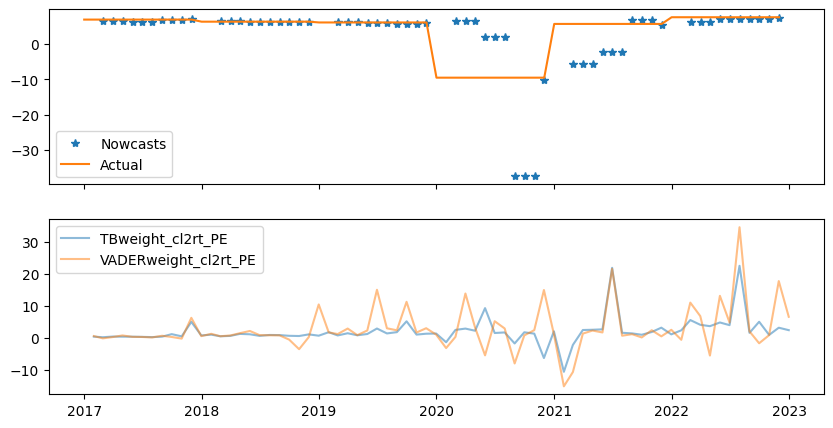

In [12]:
results = runAR(lag=1, window=0)
# results = pd.read_csv('Results/AR(1)_W0_summary.csv', parse_dates=['date'])
tweets = load_tweets().loc[dt.datetime(2017,1,1):,:]
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(results['date'], results['Nowcast'], linewidth=0, marker='*', label='Nowcasts')
axs[0].plot(results['date'], results['Actual'], label='Actual')
for metric in tweets.columns:
    axs[1].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[0].legend()
axs[1].legend()
fig.show()
results